# SVM RBF Kernel
- Pick a classification dataset from the LIBSVM repository:
- Run SVM to train a classifier, using a radial basis function as a kernel function. 
- Apply cross-validation to evaluate different combinations of values of the model parameters 
 (box constraint C and kernel parameter γ).
   - a) How sensitive is the cross-validation error to changes in C and γ? 
   - b) Choose the combination of C and γ that minimizes the cross-validation error
   - c) Train the SVM on the entire dataset and report the total classification error.

* Advice: use a logaritmic range for parameter γ.



In [187]:
# %matplotlib inline
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_svmlight_file
from sklearn.svm import SVC  
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [188]:
# Utility function to move the midpoint of a colormap to be around
# the values of interest.

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [189]:
# Pick a classification dataset, load the file and read the labels in Y and data in X
#X, Y = load_svmlight_file('/Users/aideenf/Desktop/Datasets/diabetes_scale.svm')
X, Y = load_svmlight_file('diabetes_scale.svm')

#Split the data into training/test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 100)

In [190]:
# A Support Vector Machine (SVM) is a discriminative classifier formally defined by a separating hyperplane. 
# In other words, given labeled training data (supervised learning), the algorithm outputs an optimal hyperplane
# which categorizes new example. SVM differs from the other classification algorithms by the way in which it chooses
# the decision boundary to maximize the distance from the nearest data points of all the classes. 
# An SVM doesn't merely find a decision boundary; it finds the most optimal decision boundary, the one which has 
# maximum margin from the nearest points of all the classes. The nearest points from the decision boundary 
# that maximize the distance between the decision boundary and the points are called support vectors (the maximum 
# margin classifier) https://stackabuse.com/implementing-svm-and-kernel-svm-with-pythons-scikit-learn/

# The Radial basis function kernel, also called the RBF kernel, or Gaussian kernel, is a kernel that 
# is in the form of a radial basis function (more specifically, a Gaussian function). The RBF kernel is defined as
# http://pages.cs.wisc.edu/~matthewb/pages/notes/pdf/svms/RBFKernel.pdf

# When training an SVM with the Radial Basis Function (RBF) kernel, two hyperparameters can be considered:
# The box constraint(C) and gamma. 


### Box constraint C ###### 
# The basic idea is that when the data is not perfectly separable, the training algorithm 
# must allow some mis-classification in the training set. In this case it is applying a cost to the misclassification.
# The higher the box-constraint the higher the cost of the misclassified points, leading to a more strict separation
# of the data. The C parameter trades off correct classification of training examples against maximization 
# of the decision function’s margin. For larger values of C, a smaller margin will be accepted if the decision 
# function is better at classifying all training points correctly. A lower C will encourage a larger margin, 
# therefore a simpler decision function, at the cost of training accuracy. In other words``C`` behaves as a 
# regularization parameter in the SVM. So the parameter C, common to all SVM kernels, trades off misclassification 
# of training examples 
# against simplicity of the decision surface. A low C makes the decision surface smooth, while a high C 
# aims at classifying all training examples correctly. 

### Gamma(γ) #################
# gamma defines how much influence a single training example has. The larger gamma is, the closer 
# other examples must be to the decision vectors to be affected. Intuitively, the gamma parameter defines how far 
# the influence of a single training example reaches,with low values meaning ‘far’ and high values meaning ‘close’. The gamma parameters can be seen as the
# inverse of the radius of influence of samples selected by the model as support vectors.

#Proper choice of C and gamma is critical to the SVM’s performance.



In [201]:
# GAMMA and C configuration
# our hint is to "use logritmmic range" for gamma: 
# "Notice an interesting thing about the logarithmic scale: 
# the distance from 1 to 2 is the same as the distance from 2 to 4, or from 4 to 8. 
# In fact any equal multiplication has the same distance: so 1 to 3 is the same as 3 to 9."

# use np.geomspace to define logritmic range (similar to logspace)
#start: the starting value of the sequence.
#stop : the final value of the sequence
#num  : Number of samples to generate. Default is 50.

#QUESTION: HOW DO WE KNOW WHAT RANGE TO USE
# "To determine good values (by Cross Validation), 
# it is important to search on the right scale. We therefore fix default values for C and σ 
# that have the right order of magnitude: In a c-class problem we use the 1/c quantile of the pairwise 
# distances of all data-points as a default for σ. 
# The default for C is the inverses of the empirical variance s2 in features space. "

# https://stats.stackexchange.com/questions/43943/which-search-range-for-determining-svm-optimal-c-and-gamma-parameters
# for the purpose of the homework we will just set like this...


C_range = np.geomspace(.01, 1000, 20)
gamma_range = np.geomspace(.00001, 1000, 20)
param_grid = dict(gamma=gamma_range, C=C_range)


In [202]:
# -----Apply cross-validation to evaluate different combinations of values of the model parameters----
# INITIALISE THE CROSS_VALIDATIOR
# Stratified ShuffleSplit cross-validator Provides train/test indices to split data in train/test sets.
# This cross-validation object is a merge of StratifiedKFold and ShuffleSplit, which returns stratified
# randomized folds. The folds are made by preserving the percentage of samples for each class.
# Note: like the ShuffleSplit strategy, stratified random splits do not guarantee that all folds will be different,
# although this is still very likely for sizeable datasets.

cross_validate = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=42)

In [203]:
# GridSearchCV is a "grid-search" on C and γ using cross-validation.
# Various pairs of (C,γ) values are tried and the one with the best cross-validation accuracy are returned.
# one of the input paramaters is our C and gamma range, these ranges will be used.
# σ is for the RBF kernel and C for the SVM. 
# THIS SECTION OF CODE TAKES 10s or so to run. 

grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cross_validate)
grid.fit(X_train, Y_train)
scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))

print(scores)
mean = scores.mean()

[[0.65432099 0.65432099 0.65432099 0.65432099 0.65432099 0.65432099
  0.65432099 0.65432099 0.65432099 0.65432099 0.65432099 0.65432099
  0.65432099 0.65432099 0.65432099 0.65432099 0.65432099 0.65432099
  0.65432099 0.65432099]
 [0.65432099 0.65432099 0.65432099 0.65432099 0.65432099 0.65432099
  0.65432099 0.65432099 0.65432099 0.65432099 0.65432099 0.65432099
  0.65432099 0.65432099 0.65432099 0.65432099 0.65432099 0.65432099
  0.65432099 0.65432099]
 [0.65432099 0.65432099 0.65432099 0.65432099 0.65432099 0.65432099
  0.65432099 0.65432099 0.65432099 0.65432099 0.65432099 0.65432099
  0.65432099 0.65432099 0.65432099 0.65432099 0.65432099 0.65432099
  0.65432099 0.65432099]
 [0.65432099 0.65432099 0.65432099 0.65432099 0.65432099 0.65432099
  0.65432099 0.65432099 0.65432099 0.65432099 0.65432099 0.65432099
  0.65432099 0.65432099 0.65432099 0.65432099 0.65432099 0.65432099
  0.65432099 0.65432099]
 [0.65432099 0.65432099 0.65432099 0.65432099 0.65432099 0.65432099
  0.65432099 0.6

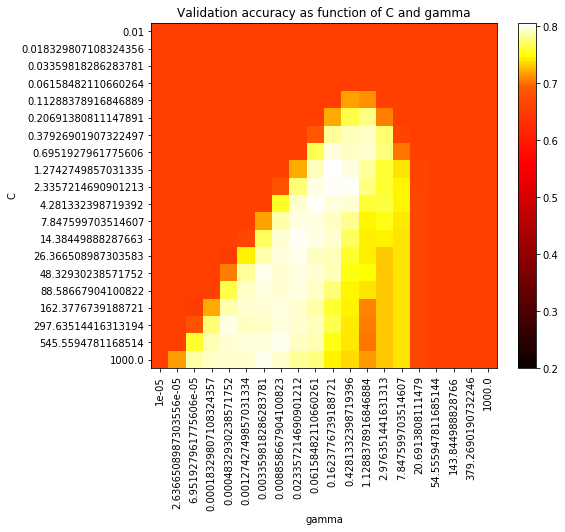

In [204]:
# Draw heatmap of the validation accuracy as a function of gamma and C
#
# The score are encoded as colors with the hot colormap which varies from dark
# red to bright yellow. As the most interesting scores are all located in the
# 0.7ish range we use a custom normalizer to set the mid-point to 0.7 so
# as to make it easier to visualize the small variations of score values in the
# interesting range

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=mean))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=90)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy as function of C and gamma')
plt.show()

In [205]:
# Extract C value from datatype dict
print("The parameters to minimise the cross validation error are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

C_value = grid.best_params_['C']
gamma_value = grid.best_params_['gamma']

# print(scores)

#train the SVM on the entire dataset and report the total classification error.
rbf_svc = SVC(kernel='rbf', C=C_value, gamma=gamma_value)
rbf_svc.fit(X, Y)
Y_pred = rbf_svc.predict(X)
accuracy = accuracy_score(Y,Y_pred)*100
print("The Accuracy: %s "
      % (accuracy))

The parameters to minimise the cross validation error are {'C': 1.2742749857031335, 'gamma': 0.1623776739188721} with a score of 0.81
The Accuracy: 78.90625 


# Results:
    
- The parameters to minimise the cross validation error are {'C': 1.27, 'gamma': 0.16} with a score of 0.81

- The Accuracy: 78.9%, therefor the the classification error is 21.1%

-  The cross validation error is quite sensitive to changes in gamma and C:

    - When gamma is very small, the model is too constrained and cannot capture the complexity(shape) of the data. The region of influence of any selected support vector would include the whole training set. 
    
    - When gamma gets too large, the radius of the area of influence of the support vectors only includes the support vector itself and C has no effect on the overfitting. 
    
    - For some values of Gamma the preformance is similar when C is either very small or very large although a lower value of C might be better choice from computational perspective.

    -  Good models can be found on a diagonal of C and gamma. Smooth models (lower gamma values) can be made more complex by increasing the importance of classifying each point correctly (larger C values) so there is a diagonal of good c and gamma values. 



In [206]:
#https://github.com/Jam3/math-as-code